##  Chapter 11: Linear unsupervised learning

# 11.2  Principal Component Analysis - learning spanning sets

The most fundamental *unsupervised learning* method - known as *Principal Component Analysis* (or *PCA* for short) follows directly from our discussion in the previous Section regarding fixed basis representations with one crucial caveat: now we aim to learn not only the best linear combination of a set of $K \leq N$ spanning vectors to represent $N$ dimensional points as best as possible, but the best set of spanning vectors themselves as well.

Once we have derived PCA we will then discuss a number of popular applications of the technique - with an emphasis on two major areas.  The first application is to supervised learning datasets, where PCA is used to learn a complete $K=N$ dimensional spanning set for use as an advanced version of *feature scaling* / *data normalization*.  This is typically referred to as *sphereing*.  For unsupervised learning datasets, that is data consisting of input points alone, PCA is often used to learn a lower dimensional $K < N$ representation that is easier for human beings to interpret.

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ortho_group  # Requires version 0.18 of scipy

# custom libs
from mlrefined_libraries import unsupervised_library as unsuplib
from mlrefined_libraries import basics_library as baslib
datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 11.2.1  Perfectly representing data via a learned spanning set

Imagine we go back to the start in Section 1.1 where we first started discussed how - given a fixed basis or spanning set of $N$ vectors $\mathbf{c}_1,\,\mathbf{c}_2,...,\mathbf{c}_N$ - to represent a set of $P$ mean-centered points $\mathbf{x}_1,\,\mathbf{x}_2,...,\mathbf{x}_P$ exactly as

\begin{equation}
\sum_{n=1}^N \mathbf{c}_n w_{n,\,p} = \mathbf{x}_p  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P
\end{equation}

where the weights $w_{p,n}$ we saw can be learned by minimizing a Least Squares cost function.  Before we supposed the spanning set / basis was fixed - here we will *learn* it along with the ideal weights.  This slight twist on the theme of fixed basis representation is called *Principal Component Analysis*, for reasons we discuss below.

In order to make this adjustment all we first need to do is minimize the Least Squares cost function we saw in equation (12) over the set of basis elements $\mathbf{c}_1,\,\mathbf{c}_2,\,...,,\mathbf{c}_N$.  Here we will use the same matrix notation $\mathbf{C}$ to compactly represent these $N$ basis elements.  Adding this to the list of optimization variables we need to minimize with respect to, this cost function (mirroring equation (12)) is 

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P,\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

Again - the only thing that has changed here is that now (since we aim to learn the basis $\mathbf{C}$ as well) the basis $\mathbf{C}$ has been added to the list of variables we wish to minimize this cost function with respect to.  

Likewise - mirroring equation (13) - the formal problem of minimizing this Least Squares cost mirrors the minimization can now be written as

\begin{equation}
\underset{\mathbf{w}_1,\mathbf{w}_2,...,\mathbf{w}_P,\mathbf{C}}{\text{minimize}} \,\, \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

This cost function can be properly minimized using any number of standard approaches like e.g., gradient descent or block-coordinate descent (see Section 9.2.5).  However it is far more common to go one step further enforce the assumption of an *orthonormal* basis which -  mirroring how orthonormality reduces the formula for learning the weights of a fixed spanning set - here it drastically reduces the complexity of solving the Least Squares cost above.  Beyond its computational simplicity,  the orthonormal solution is also particularly useful for a range of applications like data normalization and data analysis (which we explore in the examples of the next Subsection).

## 11.2.2  Perfect representation using a learned orthonormal spanning set

In Section 1.1 we also saw that when a basis is *orthonormal* - i.e., that $\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{N\times N}$ - that the update formula for the weight vectors collapses from a linear system we must solve to a simple inner product calculation.  In our current context - where we aim to learn a proper basis - the *restriction* to such bases likewise drastically reduces the complexity of the above calculations - for both the weight vectors *and* the optimal basis. While unraveling the simple formula driven by the consequences of the orthonormal assumption takes some effort, the end result is well worth the effort.  Moreover - due to its simplicity and statistical interpretation - the recovered orthonormal basis we describe here is by far the most commonly used form of Principal Component Analysis used in practice.

To begin, note that we can restrict ourselves to only orthonormal bases by constraining the Least Squares cost function in equation (27) so that 
$\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{N\times N}$, and we can express this adjustment formally by adding the constraint to equation (28) as 

\begin{equation}
\begin{aligned}
\underset{\mathbf{w}_1,\mathbf{w}_2,...,\mathbf{w}_P,\mathbf{C}}{\,\,\,\,\,\mbox{minimize}\,\,\,} & \,\,\,\, \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2    \\
\mbox{subject to}\,\,\, & \,\,\,\,\,  \mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{N\times N}. \,\,\,\,\,\, 
\end{aligned}
\end{equation}

As we will see by studying this constrained problem, we can but need not use a formal iterative method (e.g., coordinate descent, gradient descent) to solve the above problem. 

So suppose we enforce the orthonormal constraint - what happens to our cost function?  Immediately we can say - from either equation (29) or its precursor in Section 1.1 equation (15) - that irregardless of the actual value of $\mathbf{C}$ the formula for an ideal set weights for our basis will always be given by the compact / formula

\begin{equation}
\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P .
\end{equation}

 

Previous in Section 1 we emphasized the benefit of this update - it is far more computationally efficient than solving linear systems (which we must do when the basis is not orthonormal).  Here since we are  learning $\mathbf{C}$ (as opposed to it being fixed) this benefit is magnified: *the constraint that our basis must be orthonormal makes our weight vectors completely redundant*.  In other words, replacing the weight vectors in our cost function in equation (7) with the updates given above our cost function becomes

\begin{equation}
g\left(\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2
\end{equation}

which is a function of $\mathbf{C}$ alone.  

Let us briefly examine one summand of this reduced cost function.  Expanding the of the $p^{th}$ summand and using our assumption that $\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{N\times N}$ we can see that it may be re-written equivalently as

\begin{equation}
\left \Vert \mathbf{C}_{\,}\mathbf{C}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2  = -\left\Vert \mathbf{C}^T\mathbf{x}_p \right\Vert_2^2 + \left \Vert\mathbf{x}_p\right \Vert_2^2.
\end{equation}

Since our aim is to *minimize* the summation of terms taking the form of the above, and the data point $\mathbf{x}_p$ is fixed and does not include the variable $\mathbf{C}$ we are minimizing with respect to, minimizing the original summand on the left is equivalent to minimizing *only the first term* $-\left\Vert \mathbf{C}^T\mathbf{x}_p \right\Vert_2^2$ on the right hand side.  Summing up these terms, the $p^{th}$ of which can be written decomposed over each individual basis element we aim to learn as

\begin{equation}
-\left\Vert \mathbf{C}^T\mathbf{x}_p \right\Vert_2^2 = -\sum_{n=1}^N \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2,
\end{equation}

gives us the equivalent cost function to minimize for our ideal orthonormal basis

\begin{equation}
g\left(\mathbf{C}\right) = -\frac{1}{P}\sum_{p=1}^P \sum_{n=1}^K  \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2.
\end{equation}

Again note that the cost function no longer is a function of the weight vectors $\mathbf{w}_p$ - our orthogonality assumption removes the need for us to use optimization to recover their optimal values directly (since in this case they are defined entirely in terms of the optimal basis). 

Studying this reduced form of our cost function we can see that it *decomposes completely over the basis vectors $\mathbf{c}_n$*, i.e., there are no terms where $\mathbf{c}_i$ and $\mathbf{c}_j$ interact when $i\neq j$.  This means - practically speaking - that we can optimize our orthonormal basis *one element at a time*.  Reversing the order of the summands above we can isolate each individual basis element over the entire dataset, writing above equivalently as 

\begin{equation}
g\left(\mathbf{C}\right) = -\frac{1}{P}\sum_{n=1}^K \sum_{p=1}^P \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2.
\end{equation}

Now we can think about minimizing our cost function one basis element at a time.  Beginning with $\mathbf{c}_1$ we first isolate only those relevant terms above, which consists of: $-\frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_1^T\mathbf{x}_p^{\,}\right)^2$.    Since there is a minus sign out front of this summation, this is the same as *maximizing* its negation which we denote as

\begin{equation}
h\left(\mathbf{c}_1\right) = \frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_1^T\mathbf{x}_p^{\,} \right)^2.
\end{equation}

Since our basis is constrained to be orthonormal the basis element $\mathbf{c}_1$ in particular is constrained to have unit-length.  Statistically speaking, the above measures the *sample variance of the dataset in the direction defined by $\mathbf{c}_1$*.  Note: this quantity is precisely the sample variance because our data is assumed to have been *mean-centered*.  Since we aim to maximize this quantity we can phrase our optimization in purely sample statistical terms as well: we aim to recover the a form of the basis vector $\mathbf{c}_1$ that points in the maximum direction of variance in the dataset.  

To determine the maximum value of the function above / determine the direction of maximum sample variance in the data we can rewrite equation (38) above by stacking the data points $\mathbf{x}_p$ column-wise - forming the $N\times P$ matrix $\mathbf{X}$ - giving the equivalent formula in 

\begin{equation}
h\left(\mathbf{c}_1\right) = \frac{1}{P}\mathbf{c}_1^T \mathbf{X}^{\,}_{\,}\mathbf{X}^T_{\,} \mathbf{c}_1^{\,} = \mathbf{c}_1^T\left(\frac{1}{P}\mathbf{X}^{\,}_{\,}\mathbf{X}^T_{\,} \right)\mathbf{c}_1^{\,}.
\end{equation}

Written in this form the above takes the form of a so-called *Rayleigh Quotient* (see [example 9 of our post on optimality conditions](https://jermwatt.github.io/mlrefined/blog_posts/Computational_Calculus/Part_13_unconstrained_optimality_conditions.html)) whose maximum can is expressible algebraically in closed form based on the [eigenvalue / eigenvector decomposition](https://jermwatt.github.io/mlrefined/blog_posts/Computational_Linear_Algebra/Part_2_eigenvalues_and_eigenvectors.html) of the matrix $\mathbf{X}^{\,}\mathbf{X}^T$ (in the middle term) or likewise the matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ (in the term on the right).  Because the matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ can be interpreted statistically as the *covariance matrix* of the data it is more common to use the particular algebraic arrangement on the right.

So, denoting denoting $\mathbf{v}_1$ and $d_1$ the eigenvector and largest eigenvalue of $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ the maximum of the above occurs when $\mathbf{c}_1 = \mathbf{v}_1$, where $h\left(\mathbf{v}_1\right) = d_1$ - which is also the variance in this direction.  Remember: this direction $\mathbf{v}_1$ points in the largest direction of variance in the dataset.  In the jargon of machine learning $\mathbf{v}_1$ is referred to as the *first principal component* of the data, hence the name *Principal Component Analysis*.

With our first basis vector in hand, we can move on to determine the second element of our ideal orthonormal spanning set.  Plucking out the relevant terms from equation (37) and following the same thought process we went through above results in the familiar looking function

\begin{equation}
h\left(\mathbf{c}_2\right) = \frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_2^T\mathbf{x}_p^{\,} \right)^2
\end{equation}

that we aim to maximize in order to recover our second basis vector.  This formula has the same sort of statistical interpretation as the analogous version of the first basis vector had above - here again it calculates the variance of the data in the direction of $\mathbf{c}_2$.  Since our aim here is to maximize - given that $\mathbf{c}_1$ has already been resolved and that $\mathbf{c}_1^T\mathbf{c}_2^{\,} = 0$ due to our orthonormal assumption - the statistical interpretation here is that we are aiming to find the *second* largest orthogonal direction of sample variance in the data.

This formula can also be written in compact vector-matrix form as $h\left(\mathbf{c}_2\right) = \mathbf{c}_2^T \left(\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T_{\,} \right)\mathbf{c}_2^{\,}$, and its maximum (given our restriction to an orthonormal basis implies that we must have $\mathbf{c}_1^T\mathbf{c}_2^{\,} = 0$) is again expressible in closed form in terms of the eigenvalue / eigenvector decomposition of the covariance matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$.  Here the same analysis leading to the proper form of $\mathbf{c}_1$ shows that the the maximum of the above occurs when $\mathbf{c}_2 = \mathbf{v}_2$ the eigenvector of $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ associated with its second largest eigenvalue $d_2$, and the variance in this direction is then $h\left(\mathbf{v}_2\right) = d_2$.  This ideal basis element / direction is referred to as the *second principal component of the data*.

More generally - following the same analysis for the $n^{th}$ member of our ideal orthonormal basis we look to maximize the familiar looking formula

\begin{equation}
h\left(\mathbf{c}_n\right) = \frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2
\end{equation}

As with the first two cases above, the desire to maximize this quantity can be interpreted as the quest to uncover the $n^{th}$ orthogonal direction of sample variance in the data.  And following the same arguments, writing the above more compactly as $h\left(\mathbf{c}_n\right) = \mathbf{c}_n^T\left(\frac{1}{P} \mathbf{X}^{\,}\mathbf{X}^T_{\,}\right)\mathbf{c}_n^{\,}$ etc.,, we can show that it takes the form $\mathbf{c}_n = \mathbf{v}_n$, where $\mathbf{v}_n$ is the $n^{th}$ eigenvector of $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ associated with its $n^{th}$ largest eigenvalue $d_n$, and here the sample variance is expressible in terms of this eigenvalue $h\left(\mathbf{c}_n\right) = d_n$.  This is learned element / direction is referred to as the $n^{th}$ principal component of the data.

----

In summary, by restricting ourselves to only orthonormal bases / spanning sets we greatly simplify the process of learning an ideal basis for our dataset, all while determining a set of basis and weights that does indeed minimize the PCA Least Squares cost function in equation (2) (i.e., the original cost function, where orthonormality was not strictly enforced).  In particular denoting the eigenvalue decomposition of the covariance matrix 
$\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T$ is given as

\begin{equation}
\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T = \mathbf{V}^{\,}\mathbf{D}^{\,}\mathbf{V}^T
\end{equation}

as we saw above the orthonormal basis we recover is given precisely by the eigenvectors above, i.e., $\mathbf{C} = \mathbf{V}$.  These are referred to in the jargon of machine learning as the *principal components* of the data.  Since this basis is orthonormal the ideal weight vector $\hat{\mathbf{w}}_p$ corresponding to the point $\mathbf{x}_p$ is then 

\begin{equation}
\hat{\mathbf{w}}_p = \mathbf{C}^T_{\,}\mathbf{x}^{\,}_p = \mathbf{V}^T_{\,}\mathbf{x}^{\,}_p
\end{equation}

Moreover, the variance in each (principal component) direction is given precisely by the corresponding eigenvalue in $\mathbf{D}$.

Finally a practical note.  As discussed previously it is often helpful to slightly *regularize* a matrix prior to computing its eigenvalues/vectors to avoid natural numerical instability issues associated with their computation.  Here this means adding a small weighted identity $\lambda\mathbf{I}_{N\times N}$, where $\lambda \geq0$ is some small value (like e.g., $10^{-5}$), to the covariance matrix prior to computing its eigenvalues/vectors.  In short, in order to avoid computational trouble we typically compute principal components of the regularized covariance matrix $\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T  + \lambda \mathbf{I}_{N\times N}$ instead of the raw covariance matrix itself.

### PCA algorithm  (orthonormal solution) 

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> dataset $\mathbf{x}_1,...,\mathbf{x}_P$ stacked column-wise into a $N\times P$ data matrix $\mathbf{X}$, regularization parameter $\lambda$ <br>

<strong>2:</strong>&nbsp;&nbsp; <code>compute</code> mean of dataset $\boldsymbol{\mu} = \frac{1}{P}\sum_{p=1}^P\mathbf{x}_p$ and center data as $\mathbf{x}_p \longleftarrow \mathbf{x}_p - \boldsymbol{\mu}$ for $p=1,...,P$ <br> 

<strong>3:</strong>&nbsp;&nbsp; <code>compute</code>  $\frac{1}{P}\mathbf{X}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$ (regularized correlation matrix)<br> 

<strong>4:</strong>&nbsp;&nbsp; <code>compute</code>
$\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T +\lambda \mathbf{I}_{N\times N}= \mathbf{V}^{\,}\mathbf{D}^{\,}\mathbf{V}^T$ (eigenvalue / vector decomposition of correlation matrix)
<br>

<strong>5:</strong>&nbsp; <strong>output:</strong> optimal principal components PCA basis $\mathbf{V}$ and weights $\hat{\mathbf{w}}_p^{\,} = \mathbf{V}^T\mathbf{x}_p^{\,}$ for $p=1,...,P$ <br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

The ``Python`` cell below contains implementations of each fundamental idea here - data centering, principal component computation, and the PCA transformation.

In [4]:
def center(X):
    '''
    A function for normalizing each feaure dimension of an input array, mean-centering
    and division by its standard deviation
    
    '''
    X_means = np.mean(X,axis=1)[:,np.newaxis]
    X_normalized = X - X_means

    return X_normalized

def compute_pcs(X,lam):
    '''
    A function for computing the principal components of an input data matrix.  Both
    principal components and variance parameters (eigenvectors and eigenvalues of XX^T)
    are returned
    '''
    # create the correlation matrix
    P = float(X.shape[1])
    Cov = 1/P*np.dot(X,X.T) + lam*np.eye(X.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    D,V = np.linalg.eigh(Cov)
    return V, D

def pca_transform_data(X,**kwargs):
    '''
    A function for producing the full PCA transformation on an input dataset X.  
    '''
    # user-determined number of principal components to keep, and regularizer penalty param
    num_components = X.shape[0]
    if 'num_components' in kwargs:
        num_components = kwargs['num_components']
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']
    
    # compute principal components
    V,D = compute_pcs(X,lam)
    V = V[:,-num_components:]
    D = D[-num_components:]

    # compute transformed data for PC space: V^T X
    W = np.dot(V.T,X)
    return W,V,D

#### <span style="color:#a50e3e;">Example 1: </span>  A simple example learning a spanning set via Principal Component Analysis 

In this example we illustrate the PCA basis - and transformed feature space - using a two-dimensional dataset.  This example mirrors the second part of Example 1 above precisely, only here we learn a basis of two spanning vectors via PCA instead of picking two fixed ones.  In the left panel we plot the mean-centered data, along with its two principal components (pointing in the two orthogonal directions of greatest variance in the dataset).  We find these by stacking the mean-centered data column-wise into the matrix $\mathbf{X}$ and determining the eigenvalue / vector decomposition of $\frac{1}{P}\mathbf{X}^{,}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$, as detailed above.  We provide just this sort of  functionality in the ``Python`` cell below.

In the right panel we show the *transformed feature space* - whose coordinate axes are now the eigenvectors $\mathbf{v}_1$ and $\mathbf{v}_2$.  Each point $\mathbf{x}_p$ in the left panel corresponds to the tuned weight vector $\mathbf{w}_p$ in the right panel.  Remember: because the PCA basis is orthonormal these weights are given precisely as $\mathbf{w}_p = \mathbf{C}^T_{\,}\mathbf{x}^{\,}_p = \mathbf{V}^T_{\,}\mathbf{x}^{\,}_p$.  Also notice: in the transformed feature space provided by the PCA basis the data has simply been rotated so that its two orthogonal directions of variance perfectly align with the horizontal / vertical axes of the space.  

<IPython.core.display.Javascript object>


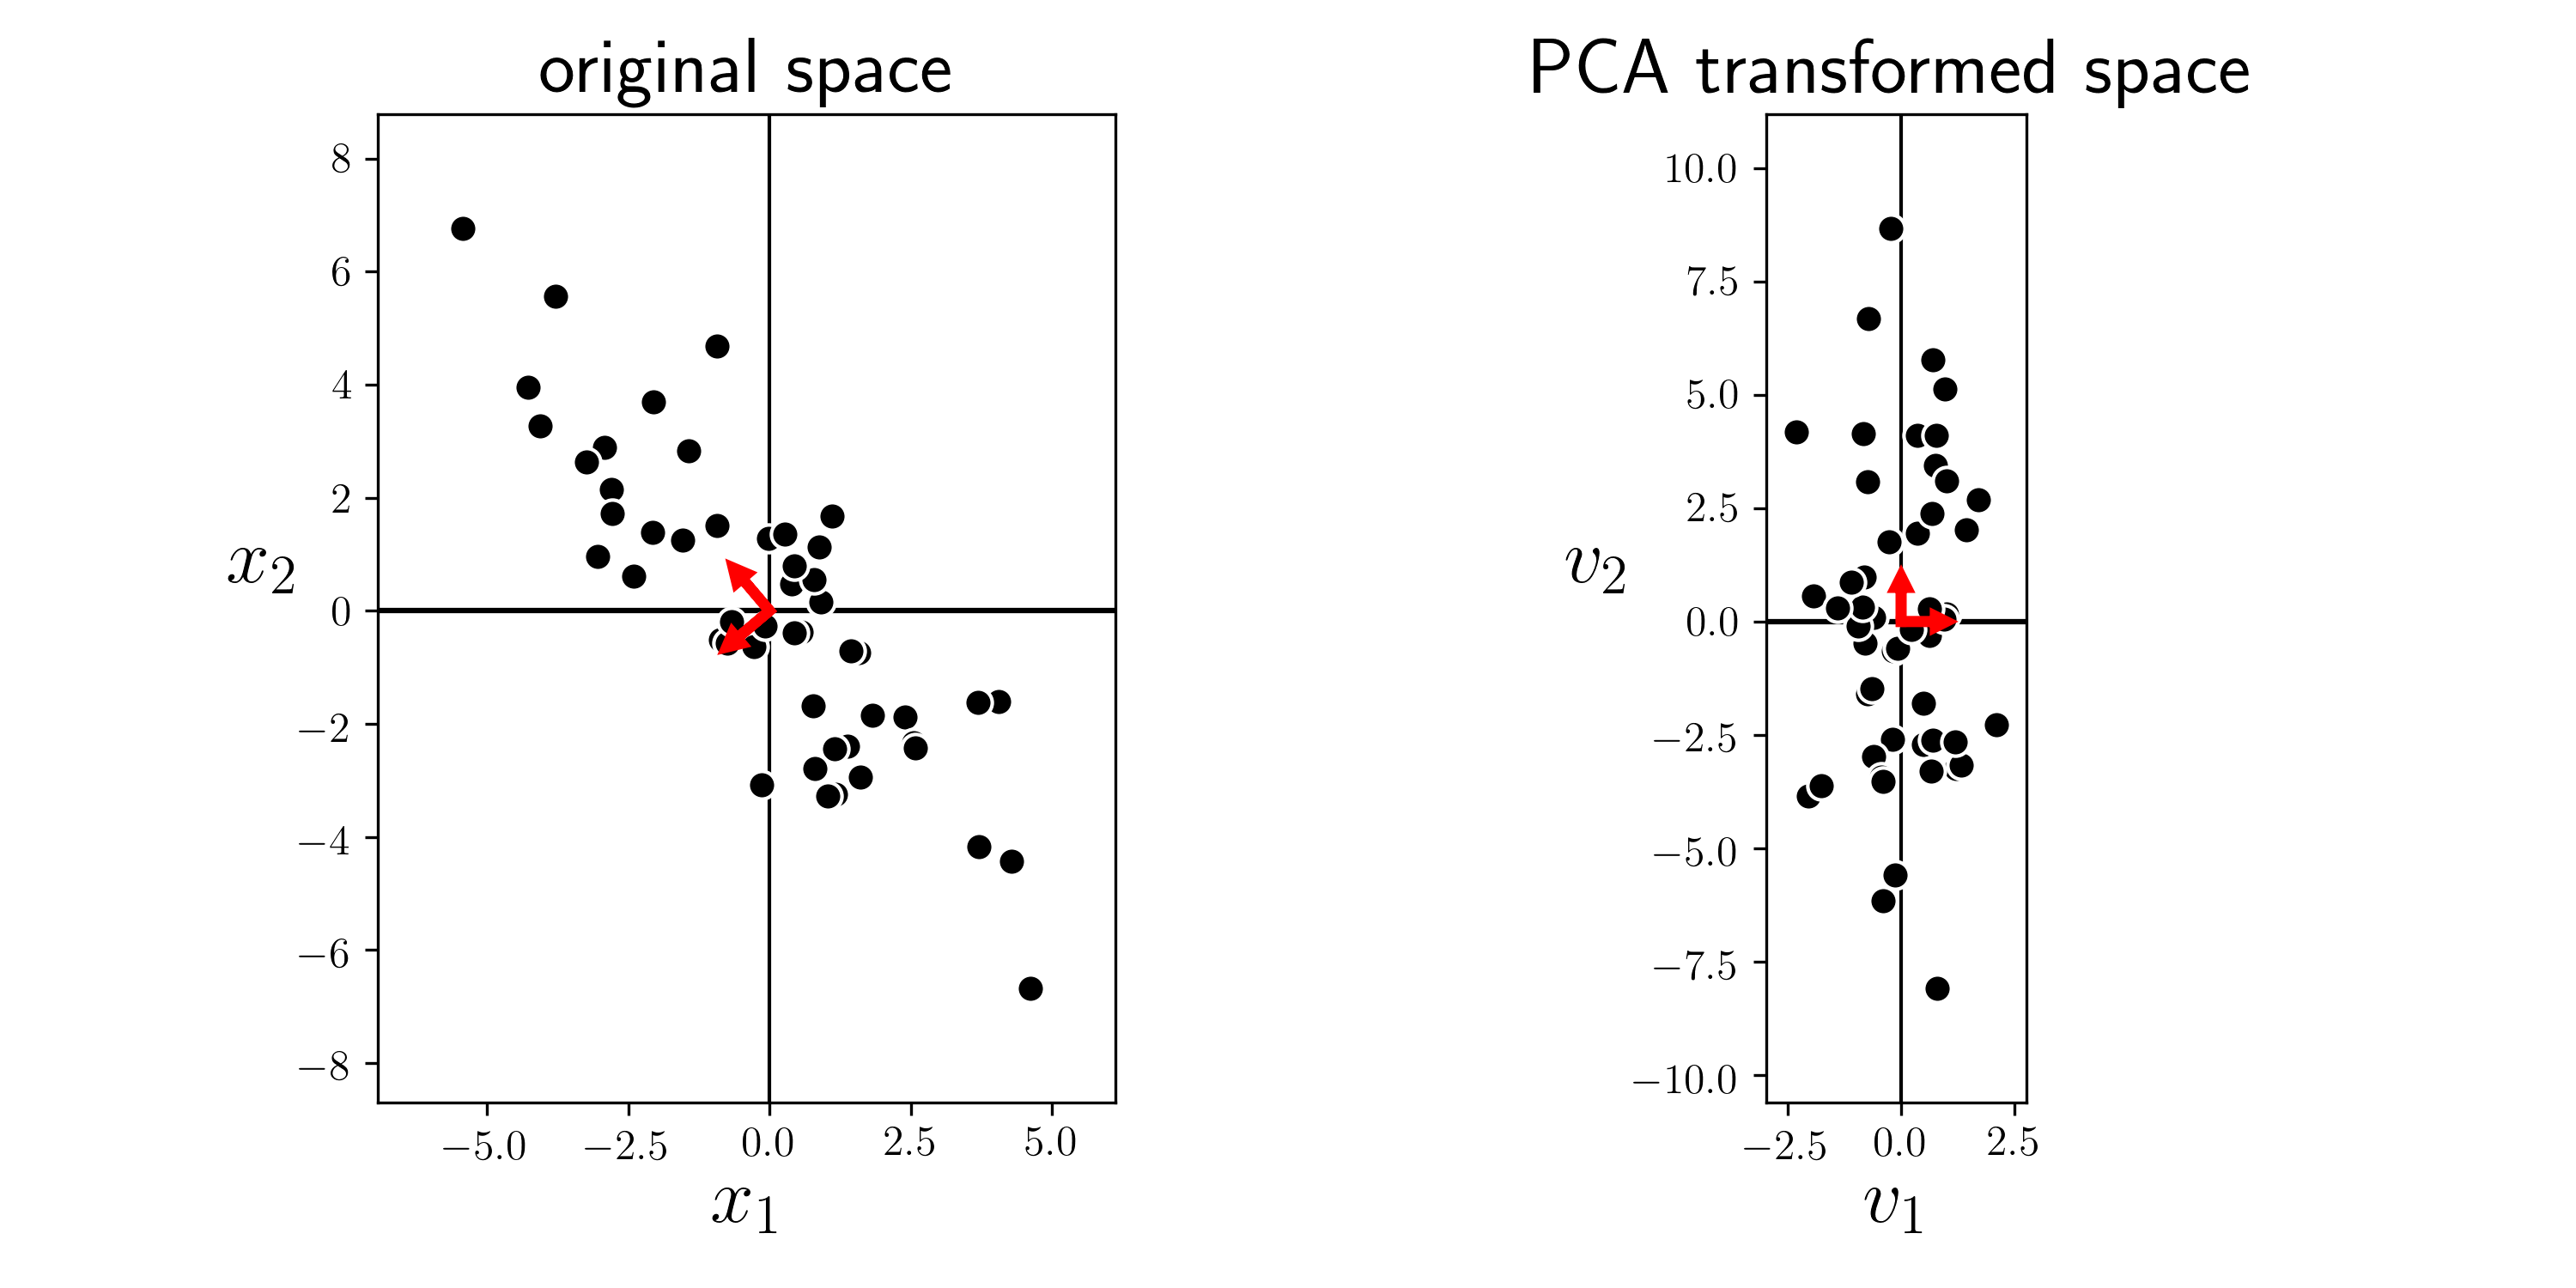

In [98]:
# load in dataset to perform PCA on, and mean-center
X_original = np.loadtxt(datapath + '2d_span_data.csv',delimiter=',')

# mean-center the data
X = center(X_original)

# compute the full PCA transformation of dataset
W,pcs = pca_transform_data(X)

# plot data in original and pca-transformed spaces
unsuplib.PCA_demos.pca_visualizer(X,W,pcs)

#### <span style="color:#a50e3e;">Example 2: </span>  Using Principal Component Analysis to sphere data for supervised learning: PCA-sphereing

Previously we have seen  with linear regression / classification how normalizing a dataset - by subtracting off the mean and dividing by the standard deviation along each of its feature dimensions - helps dramatically improve (or *condition*) the contours of a cost function, allowing gradient and coordinate descent methods to converge much faster than they typically would otherwise.

The spanning set provided by Principal Component Analysis is often used to perform this sort of normalization to supervised learning data as well - but actually goes one step further.  Because the principal components identify the orthogonal directions of greatest variance, and the transformed feature space provided by them is a perfect copy of our data rotated such that these directions align with the coordinate axes, normalizing the transformed feature space along each coordinate axes can better compact-ify our data.  For the same reasons as we have seen with the standard normalization scheme, this can greatly improve the convergence of gradient / coordinate descent.  This type of normalization - which again is used very often for supervised learning problems - is called *sphereing* (or also synonymously called *whitening*).

Since each data point is represented by $\hat{\mathbf{w}}_p = \mathbf{V}_{\,}^T\mathbf{x}_p^{\,}$ in the space spanned by the principal components, we can represent the entire set of transformed data as 

\begin{equation}
\text{(PCA transformed data)}\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\mathbf{W} = \mathbf{V}^T\mathbf{X}^{\,}.
\end{equation}

Now we aim to normalize each column of the transformed data $\mathbf{W}$.  Since these transformed features were built from a mean-centered dataset the columns of $\mathbf{W}$ are mean-centered themselves, so all that remains is to divide off the standard deviation of each column.  

This can be done in the typical way numerically - or to save computation we can conveniently the unnormalized variance of each column of $\mathbf{W}$ has already been computed in the eigen-decomposition of the regularized covariance matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$: these are precisely the eigenvalues (as mentioned in the derivation above).  In other word, since $d_n$ is the variance along the $n^{th}$ axis defined by the $n^{th}$ eigenvector $\mathbf{v}_n$ the corresponding standard deviation can be computed as its square root $\left(d_n\right)^{^1/_2}$.  So denoting $\mathbf{D}^{-^1/_2}$ the diagonal matrix whose $n^{th}$ entry is $\left(d_n\right)^{^1/_2}$, we can divide off the standard deviation each column of $\mathbf{W}$ by e.g.,
 left-multiplying by as

\begin{equation}
\text{(PCA-sphered data)}\,\,\,\,\,\,\,\,\, \mathbf{S}^{\,} = \mathbf{D}^{-^1/_2}\mathbf{W}^{\,} =  \mathbf{D}^{-^1/_2}\mathbf{V}^T\mathbf{X}^{\,}.
\end{equation}

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/pca_sphereing.png' width="120%"  height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> PCA-sphereing illustrated. </em>  </figcaption> 
</figure>

Once sphered notice that - as indicated in the figure - that 

- the data has been rotated such that the orthogonal directions of greatest variance now align with the coordinate axes

- our standard normalization (division by the standard deviation) is then performed along each axis

- after being PCA-sphered the data has unit-length covariance along each transformed input dimension: i.e., $\frac{1}{P}\mathbf{S}^{\,}\mathbf{S}^T = \mathbf{I}_{N\times N}$

A ``Python`` function for performing sphereing - based off the functionality previously provided - is below. 

In [6]:
def PCA_sphere(X,**kwargs):
    '''
    A function for producing the full PCA sphereing on an input dataset X.  
    '''
    # compute principal components
    W,V,D = pca_transform_data(X,**kwargs)
    
    # compute transformed data for PC space: V^T X
    W = np.dot(V.T,X)
    D_ = np.array([1/d**(0.5) for d in D])
    D_ = np.diag(D_)
    S = np.dot(D_,W)
    return W,S

With this function defined we can try it out on a sample dataset used in e.g., the previous example.  The next cell runs the sphereing code above, and plots comparisons of the a) the original mean-centered data (left panel), b) the PCA-transformed data (middle panel), and c) sphered data (right panel).  Here sphereing drastically improved the distribution of the original dataset, which (if this were a supervised learning dataset) will drastically improve our ability to quickly tune the parameters of a supervised model via gradient / coordinate descent.

<IPython.core.display.Javascript object>


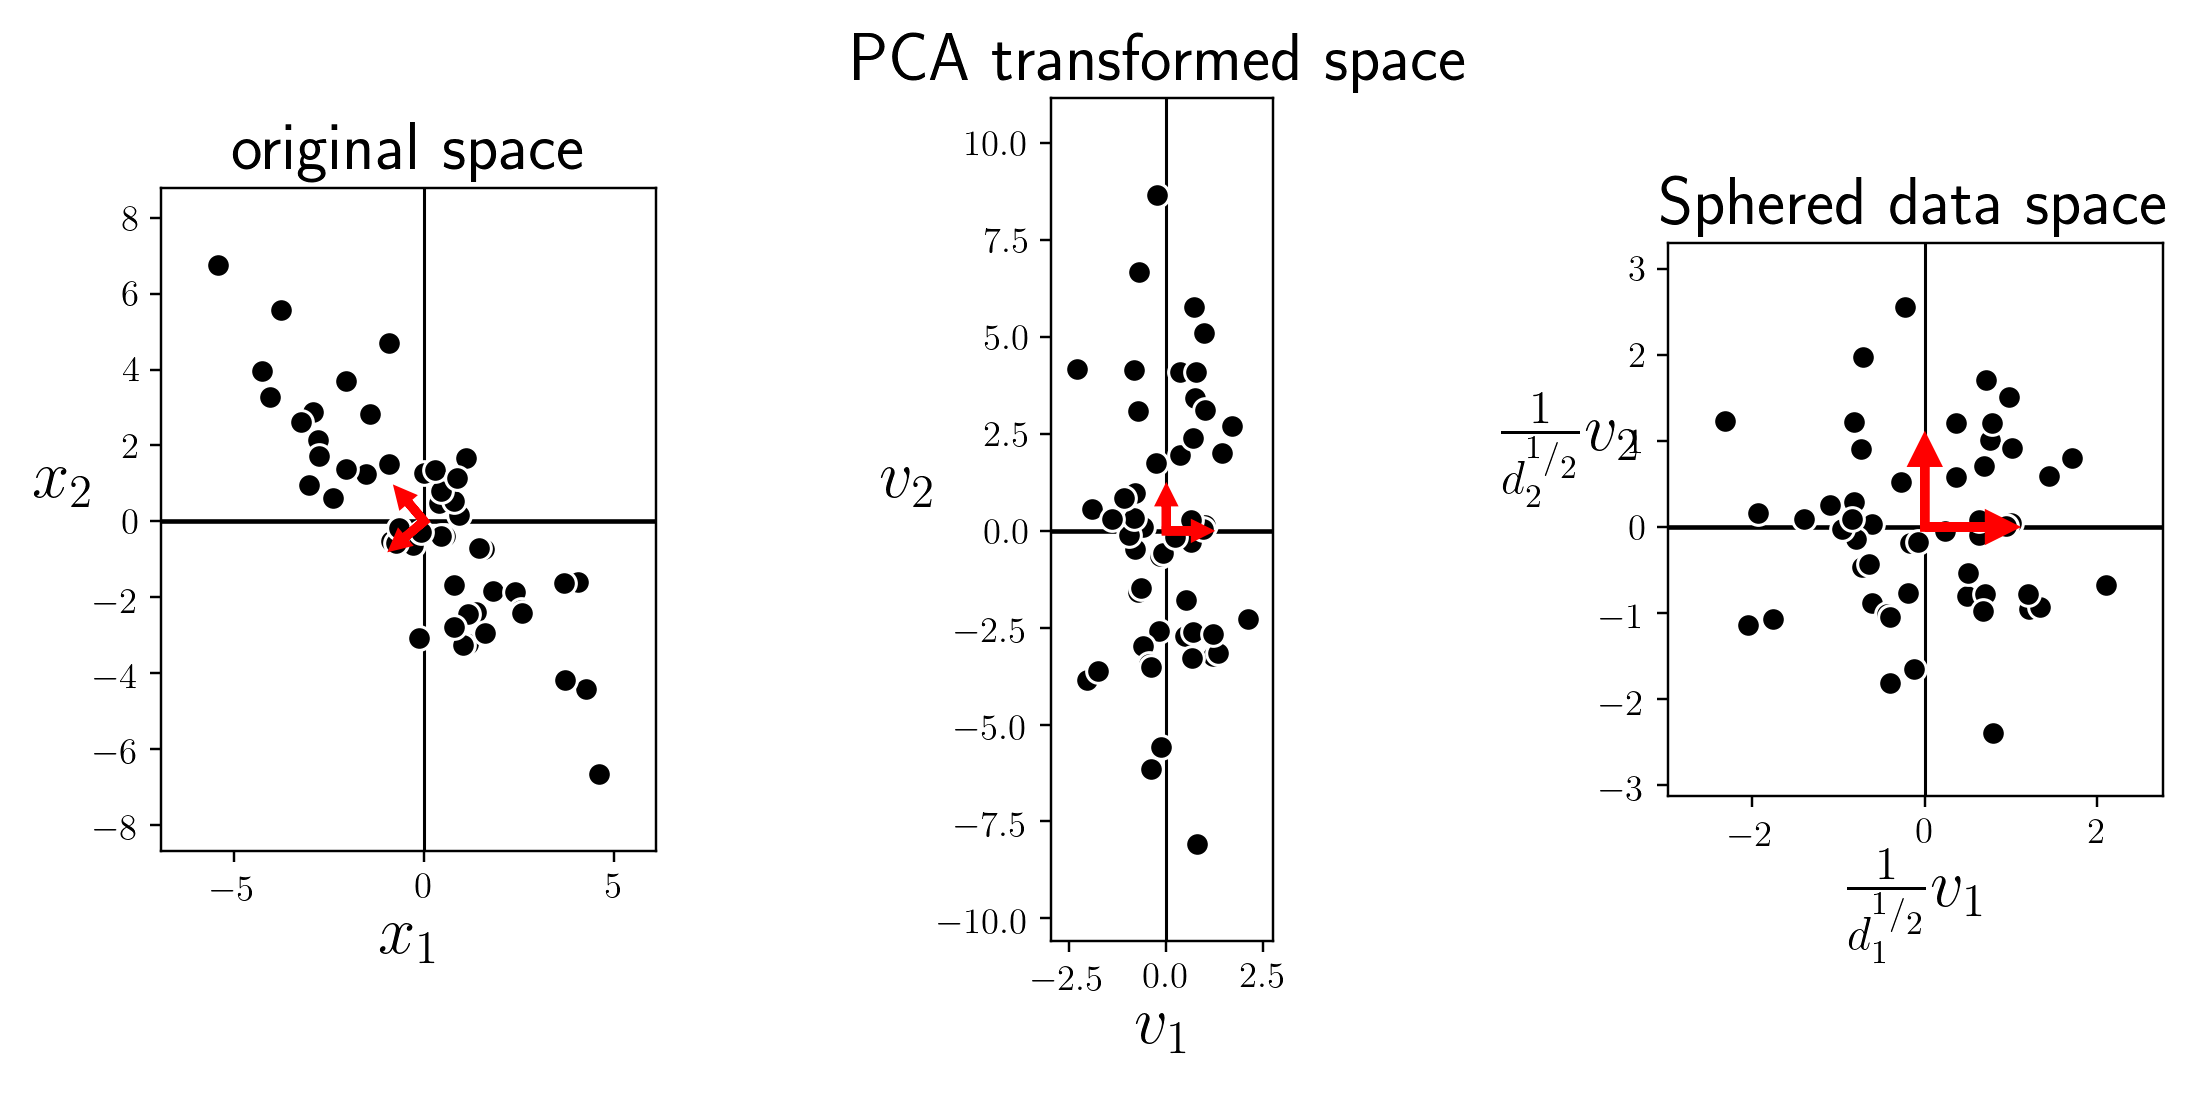

In [101]:
# load in dataset to perform PCA on
X_original = np.loadtxt(datapath + '2d_span_data.csv',delimiter=',')

# mean-center the data
X = center(X_original)

# compute the full PCA transformation of dataset
W,S = PCA_sphere(X)

# compute principal components
unsuplib.PCA_demos.sphereing_visualizer(X,W,S,pcs)

#### <span style="color:#a50e3e;">Example 3: </span>  Zero-phase Component Analysis (ZCA) sphereing

The PCA-based sphereing detailed in the previous example is generally applicable to any generic kind of data.  However in the case of images, videos, and other types of data that has inherent local *spatial correlation* structure (e.g., in an image pixels near one another are highly correlated in terms of the intensity values) we often look to leverage this special structure to improve the generalizability of a trained supervised learner.  For example in the case of image-data a carefully designed extensions of the supervised learning framework we have seen thus far - e.g., *edge detectors* more generally a *convolutional network* - are built specifically to leverage the spatial correlation in an image.  Because of this, while we would still like to employ some sort of data normalization (an important engineering factor we always aim to employ in practice, as it greatly quickens the training process), we need to make sure that our data-normalization procedure will not destroy the spatial correlation we aim to explicitly leverage via e.g., edge detectors or convolutional operations.  Does PCA-sphereing fit this bill?  

To find out we perform PCA-sphereing on a set of standard handwritten digits - a random subset of 5,000 the MNIST dataset each 28x28 pixels in length/width.  Because images are visual pieces of data we can compare data points visually before and after the PCA-sphereing process.

In the next cell we load in this dataset, and plot a sample of the MNIST dataset.

In [70]:
# load in dataset
datapath = '../../mlrefined_datasets/superlearn_datasets/'
data = np.loadtxt(datapath + 'mnist_mini_train.csv',delimiter = ',')

# divy up data into images and labels
images = data[:,:-1].T
labels = data[:,-1]

<IPython.core.display.Javascript object>


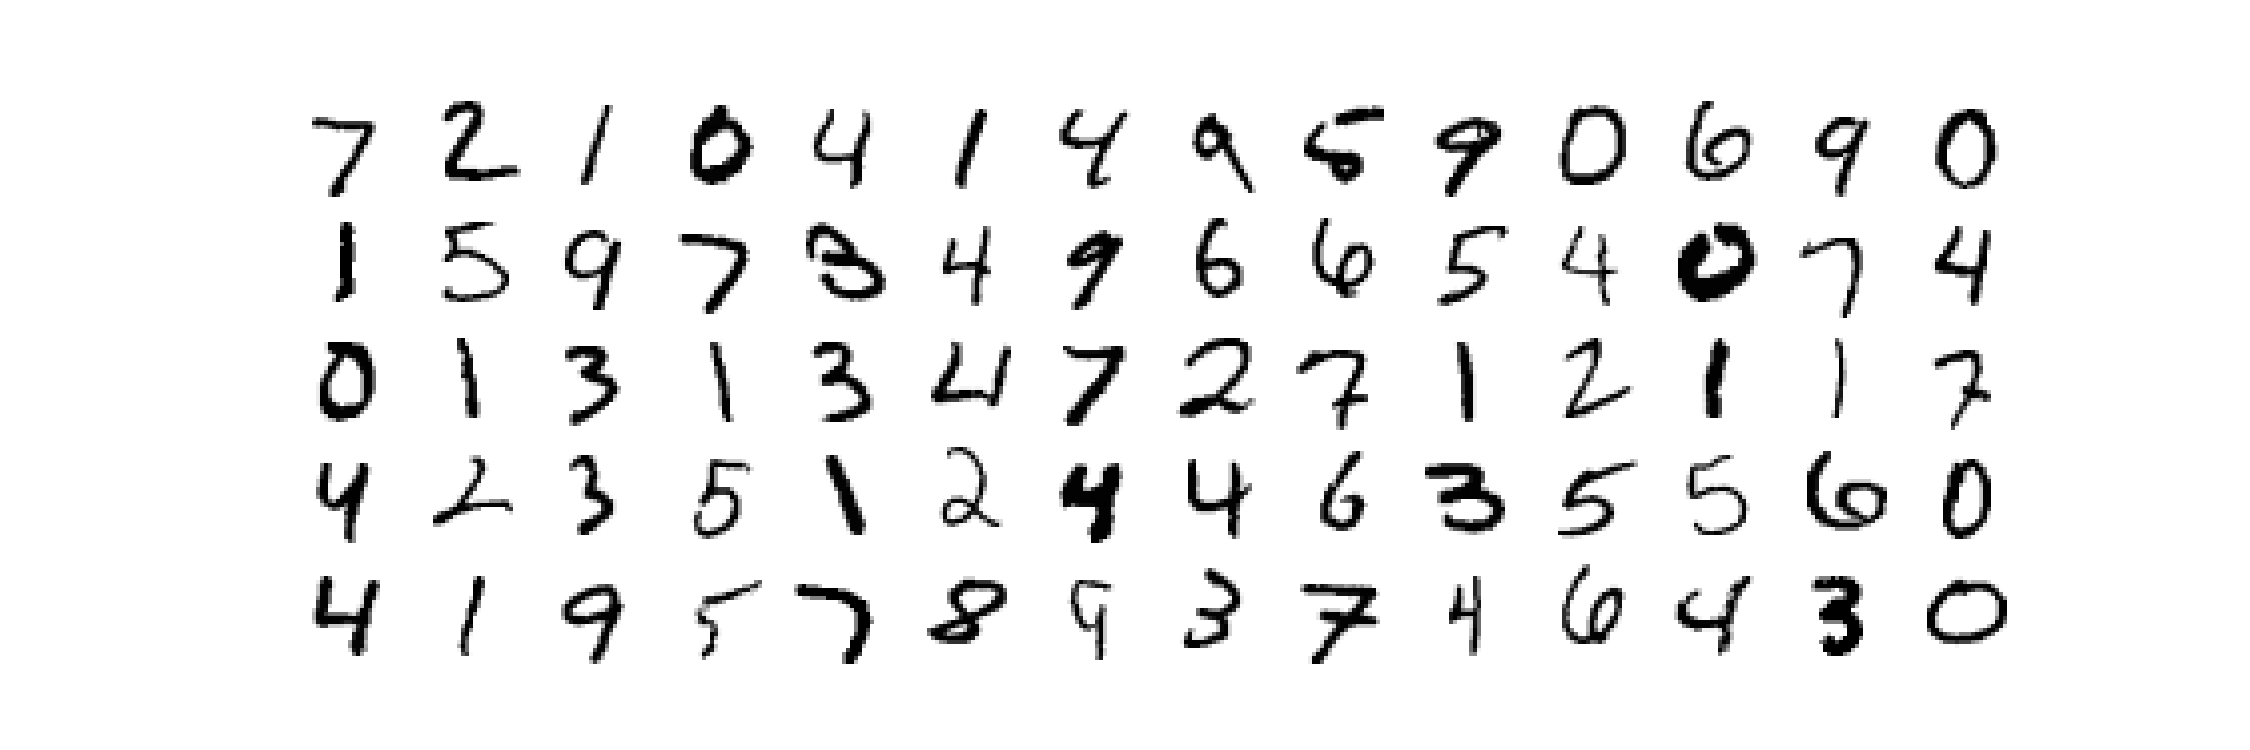

In [71]:
# plot a sample of the images
unsuplib.PCA_functionality.show_images(images)

Now we perform PCA-sphereing on this handwritten digit dataset, and plot the resulting PCA-sphered data.  Note: these are the same data points (transformed by the sphereing process, of course) we plotted above.

<IPython.core.display.Javascript object>


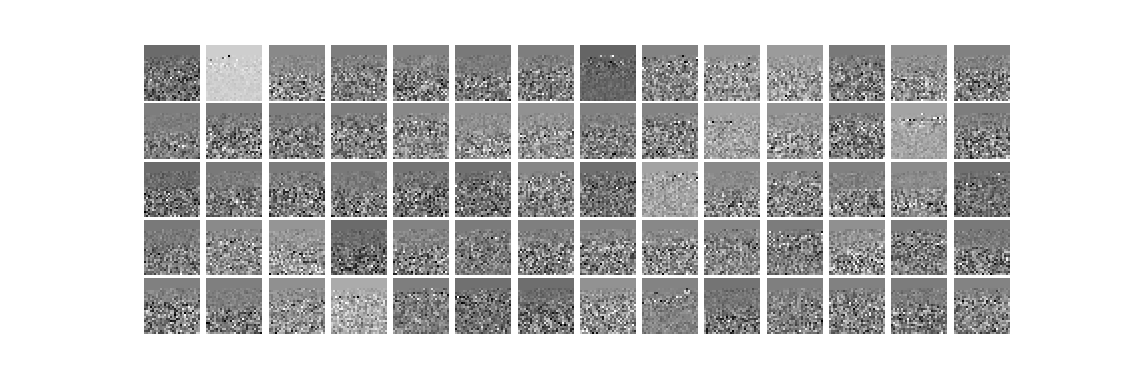

In [245]:
# mean-center the data
X = center(images)

# compute the full PCA transformation of dataset
W,S = PCA_sphere(X)

# plot PCA-sphered data
unsuplib.PCA_functionality.show_images(S)

In this instance PCA-sphereing completely destroys the spatial structure of the original images - none of the original numbers are visible in these transformed versions.  This phenomenon is true more generally: PCA-sphereing tends to destroy the spatial correlation of images, video, etc.,  What about the sphereing process we have applied is responsible for this?

As detailed in the previous Example, in terms of the actions we perform on the data itself with PCA-sphereing (or whitening) we:

- **rotate and reflect** by multiplying the data by $\mathbf{V}^T$ (where $\mathbf{V}$ is the set of eigenvectors of the data's covariance matrix) the data so that its largest orthogonal directions of variance align with the coordinate axes (this is done by the standard PCA transformation)

- **normalize** these coordinate axes by dividing by their individual standard deviations by multiplying the rotated/reflected data by $\mathbf{D}^{-^1/_2}$, the diagonal matrix of inverted square roots of the eigenvalues of the data's covariance matrix (this extra bit of normalization added to the PCA transformation to makes it the PCA-sphereing operation)

Both of these actions contribute to the destruction of spatial correlation - but it is the **rotation / reflection** component that is by far the greater culprit.  We can get a visceral sense of this fact with our current dataset by simply applying the standard PCA transform - which will rotate / reflect the space so that the largest directions of variance coincide with the coordinate axes - without normalizing the result (which led to the PCA-sphereing result above).   We do this in the next cell, and plot the resulting transformed images.

<IPython.core.display.Javascript object>


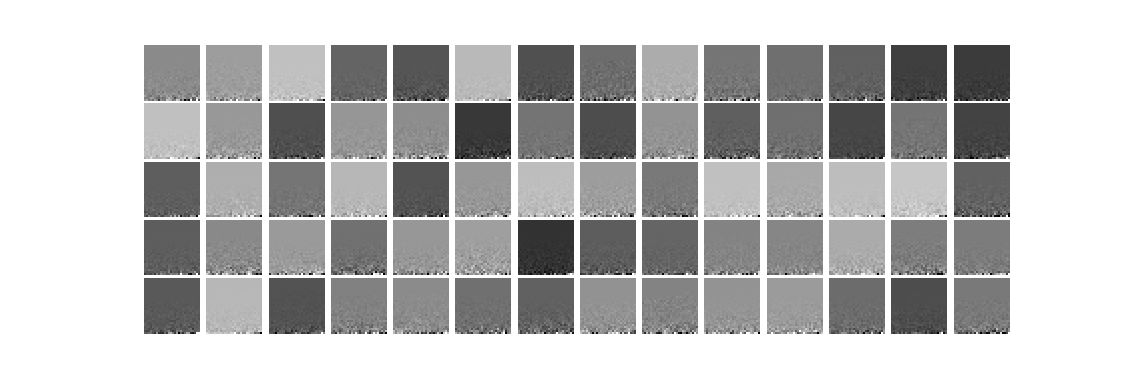

In [246]:
# mean-center the data
X = center(images)

# compute the full PCA transformation of dataset
W,V,D = pca_transform_data(X)

# plot PCA-sphered data
unsuplib.PCA_functionality.show_images(W)

As we can see in the examples plotted above, the rotation / reflection from PCA transformation utterly - created by multiplying our data by $\mathbf{V}^T$ - utterly destroys the spatial correlation structure of our images, a phenomenon that is true more generally speaking for other image datasets as well.  What can we do if we would still like the added optimization-boosting benefit of PCA-sphereing normalization but do not want to destroy the spatial correlation of our input data by rotating / reflecting it?  Well if indeed the rotation / reflection is producing the greatest challenge in terms of maintaining the spatial correlation of our data, why don't we simply rotate / reflect our dataset back to its original orientation after we finish sphereing it (i.e.,normalizing it along its largest orthogonal directions of variance)?  Since we know that it multiplication by $\mathbf{V}^T$ that produces the original rotation / reflection, multiplying by PCA-sphered data by $\left(\mathbf{V}^T\right)^{-1} = \mathbf{V}^{\,}$ (where the equality follows from the fact that $\mathbf{V}$ is an orthogonal matrix) will return the sphered data to its original orientation in the space.  This is illustrated in the Figure below.

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/zca_sphereing.png' width="110%"  height="auto" alt=""/>
  <figcaption>   
<strong>Figure 2:</strong> <em> ZCA-sphereing illustrated. </em>  </figcaption> 
</figure>

Since our PCA-sphered transformation of the input data took the form $\mathbf{S}^{\,} =  \mathbf{D}^{-^1/_2}\mathbf{V}^T\mathbf{X}^{\,}$ this re-rotation/reflection gives us the related formula

\begin{equation}
\text{(ZCA-sphered data)}\,\,\,\,\,\,\,\,\, \mathbf{Z}^{\,} =  \mathbf{V}\mathbf{S} = \mathbf{V}\mathbf{D}^{-^1/_2}\mathbf{V}^T\mathbf{X}^{\,}.
\end{equation}

For historical reasons this re-rotated version of our PCA-sphered data is often referred to as *Zero-phase Component Analysis (ZCA) sphereing*.  

We implement ZCA-sphereing in the next cell.

In [247]:
def ZCA_sphere(X,**kwargs):
    '''
    A function for producing the ZCA sphereing on an input dataset X.  
    '''   
    
    # compute principal components
    W,V,D = pca_transform_data(X,**kwargs)
    
    # PCA-sphere data
    W = np.dot(V.T,X)
    D_ = np.array([1/d**(0.5) for d in D])
    D_ = np.diag(D_)
    S = np.dot(D_,W)
    
    # rotate data back to original orientation - ZCA sphere
    Z = np.dot(V,S)
    
    return W,S,Z

With our ZCA-sphereing implementation written we can now transform the original centered dataset using it and examine the results.

<IPython.core.display.Javascript object>


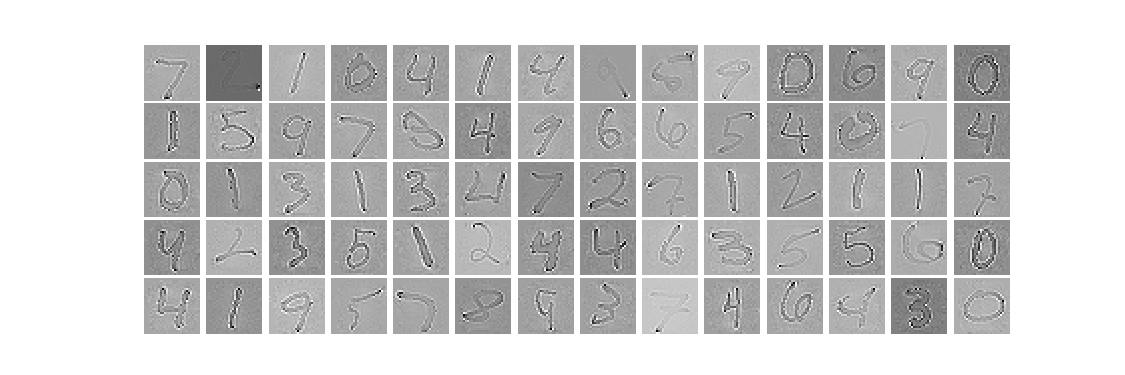

In [248]:
# mean-center the data
X = center(images)

# compute the full PCA transformation of dataset
W,S,Z = ZCA_sphere(X)

# plot PCA-sphered data
unsuplib.PCA_functionality.show_images(Z)

What a difference!  Indeed it was the rotation/reflection of PCA that destroyed most of the spatial correlation, since these ZCA-sphered images retain much of the spatial correlation present in their original versions.  Now we have the best of both worlds: a global normalization scheme (that will help speed up training) that retains the spatial structure of data leveraged e.g., by edge detectors and convolution operations.

## 11.2.3  Imperfectly representing data using a learned spanning set

We can also used PCA to find an ideal lower dimensional *linear* representation of a given set of high dimensional.  This the natural extension of the paradigm we reviewed in the previous Section - where we assumed to be given a set of $K \leq N$ spanning / basis vectors over which we represented a given set of $P$ high dimensional data points

\begin{equation}
\sum_{n=1}^K \mathbf{c}_n w_{n,\,p} \approx \mathbf{x}_p  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P
\end{equation}

only now we give ourselves more degrees of freedom by *learning* the best basis over which to represent our data.

Precisely the same sort of analysis discussed in Section 2.1 leads us to the Least Squares cost function in equation (27), only now we have only $K$ spanning set vectors in the matrix  $\mathbf{C} = 
\begin{bmatrix}
\vert \,\,\,\,\, \vert \,\,\, \cdots  \, \vert \\
\mathbf{c}_1 \,\,\, \mathbf{c}_2 \,\,\,\,\,\, \mathbf{c}_K \\
\vert \,\,\,\,\, \vert \,\,\, \cdots  \, \vert
\end{bmatrix}$ to learn.  As with the case with the full spanning set, we can use a block-coordinate approach (as shown in equations (28) and 29)) to generally minimize the Least Squares cost function, and recover an appropriate learned basis and corresponding subspace on which to project our dataset.

## 11.2.4  Imperfect representation using a learned orthonormal spanning set

Using the same argument as described in Section 2.2 we can learn the PCA orthogonal basis for an ideal $K \leq N$ dimensional linear subspace by simply computing / keeping the first $K$ principal components only.  Equivalently these are the first $K$ eigenvectors of the regularized covariance matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$ whose eigen-decomposition is $\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T + \lambda \mathbf{I}_{N\times N} = \mathbf{V}^{\,}\mathbf{D}^{\,}\mathbf{V}^T$.  Having only need for the  first $K$ columns of this matrix we denote by $\mathbf{V}_{1:K}$ the $N\times K$ matrix of the top $K$ eigenvectors.  The corresponding weights are then computed similarly to the case when $K=N$ as $\hat{\mathbf{w}}_p = \mathbf{V}_{1:K}^T\mathbf{x}_p$.

### PCA algorithm with $K \leq N$ (orthonormal solution) 

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> dataset $\mathbf{x}_1,...,\mathbf{x}_P$ stacked column-wise into a $N\times P$ data matrix $\mathbf{X}$ and number of desired principal components $K\leq N$<br>

<strong>2:</strong>&nbsp;&nbsp; <code>compute</code> mean of dataset $\boldsymbol{\mu} = \frac{1}{P}\sum_{p=1}^P\mathbf{x}_p$ and center data as $\mathbf{x}_p \longleftarrow \mathbf{x}_p - \boldsymbol{\mu}$ for $p=1,...,P$ <br> 

<strong>3:</strong>&nbsp;&nbsp; <code>compute</code>  $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$ (regularized covariance matrix)<br> 

<strong>4:</strong>&nbsp;&nbsp; <code>compute</code> the top $K$ eigenvectors of the correlation matrix $\mathbf{V}_{1:K}$
<br>

<strong>5:</strong>&nbsp; <strong>output:</strong> top $K$ principal components $\mathbf{V}$ and weights $\hat{\mathbf{w}}_p^{\,} = \mathbf{V}_{1:K}^T\mathbf{x}_p^{\,}$ for $p=1,...,P$ <br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example 4: </span>  Dimension reduction with PCA

In this example we illustrate how the orthonormal PCA basis can be used to represent a three-dimensional dataset via its ideal two-dimensional linear subspace, using the first two principal components.  In the next cell we load in the dataset first shown in Example 3, compute the orthonormal PCA spanning set based on the eigenvectors of $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$, and project the data onto the two-dimensional subspace spanned by the top two eigenvectors.  These top two eigenvectors and the subspace they span are shown in red in the left panel below, with the projected data in the subspace spanned by the top two eigenvectors are shown in the right panel.

<IPython.core.display.Javascript object>


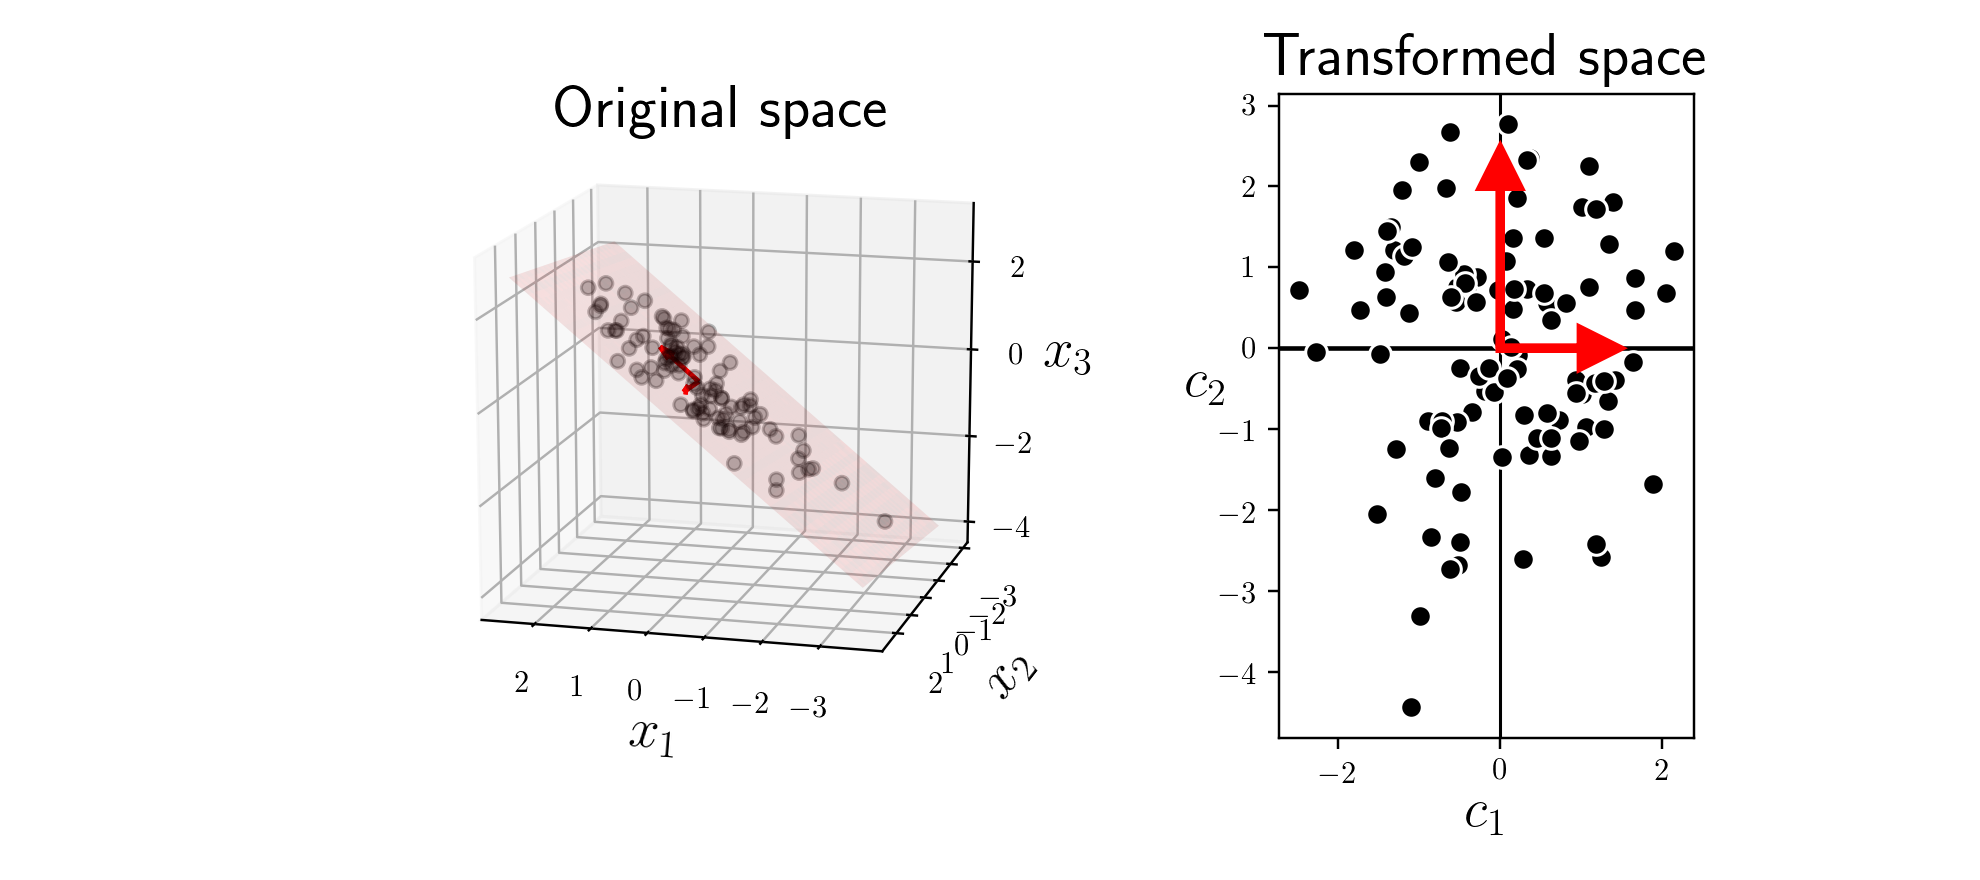

In [84]:
# load in dataset to perform PCA on
X_original = np.loadtxt(datapath + '3d_span_data.csv',delimiter=',')

# mean-center the data
X = center(X_original)

# compute the two-dimensional PCA transformation of dataset
W,pcs = pca_transform_data(X,num_components = 2)

# produce visuals
init = [15,105]
unsuplib.PCA_demos.project_data_from_3d_to_2d(X,W,pcs,init)

#### <span style="color:#a50e3e;">Example 5: </span> A warning about PCA dimension reduction and classification data

While PCA dimension reduction can technically be used for preprocessing data in a predictive modeling scenario - wherein the data is reduced in dimension in hopes of improving accuracy / computation time -  it can cause severe problems in the case of classification. In this Example we illustrate feature space dimension reduction via PCA on a simulated two-class dataset where the two classes are linearly separable. Because the ideal one-dimensional subspace in this instance runs parallel to the longer length of each class, projecting the complete dataset onto it completely destroys the separability. 

Because of this, while it is certainly common place to *sphere* classification data using PCA - as detailed in Example 6 - one needs to be extremely careful using PCA as a dimension reduction tool with classification.  

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/Fig_9_7.png' width="75%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 3:</strong> <em> (left) A toy classification dataset consisting of two linearly separable classes. The ideal subspace produced via PCA is shown in black. (right) Projecting the data onto this subspace (in other words reducing the feature space dimension via PCA) destroys completely the original separability of the data.  </em>  </figcaption> 
</figure>

## 11.2.5  The block-coordinate descent PCA solution*

While the orthonormal PCA solution is by far more popular, we could in theory recover an infinite variety of spanning sets for our data in minimizing the Least Squares cost in equation (2) using standard optimization techniques including gradient descent and block-coordinate descent.  Here we discuss in particular the *block-coordinate* descent approach hinted at in Section 9.2.1 above, where we will use $K \leq N$ elements.  The main value in going through this exercise basis is that - as we will see - PCA is the prototypical method on which all other fundamental unsupervised methods (where we cannot derive special orthonormal solutions like we can with PCA) are based.  Because of this we will often see the use of block-coordinate descent in the future, with updates that closely mirror what we derive (in the relatively simpler context of PCA).

So - how do we go about cooking up a block-coordinate descent method for minimizing the Least Squares cost for PCA in equation (2) - again assuming we use an arbitrary $K \leq N$ basis elements?  First note that there are a number of ways we can express equation (2) and multiple orders in which we could perform block-updates on its parameters.  For the sake of consistency with the natural block-update structure we will see with further unsupervised learning methods, here update *one column of parameters at a time*.  To do this we first  re-write equation (2) by expressing each multiplication $\mathbf{C}_{\,}\mathbf{w}_p = \sum_{n=1}^K\mathbf{c}_nw_{n,p}$ in terms of the *columns* of $\mathbf{C}$ (as in equation (1)).  Doing this we can write equation (2) equivalently (again assuming the use of $K \leq N$ basis vectors $\mathbf{c}_1,...,\mathbf{c}_K$) exposing each set of parameters as a column vector as 

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P,\mathbf{c}_1,...,\mathbf{c}_K\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \sum_{n=1}^K\mathbf{c}_nw_{n,\,p} - \mathbf{x}_p \right\Vert_2^2
\end{equation}

where $w_{n,\,p}$ denotes the $n^{th}$ element of $\mathbf{w}_p$.


To minimize our cost function one-column of parameters at a time we first sweep through $\mathbf{w}_1$ through $\mathbf{w}_P$, solving the first order system in each case (keeping all other parameters fixed).  Then we do the same for $\mathbf{c}_1$ through $\mathbf{c}_K$.  Beginning with the weights it is straight forward to confirm (as we computed in Section 9.1.1 when computing weights for a fixed basis representation) that the first order system for each $\mathbf{w}_p$ is given as 

\begin{equation}
\mathbf{C}^T\mathbf{C}^{\,}\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P .
\end{equation}

Since $\mathbf{C}$ is an $N \times K$ matrix, each of these systems is $K\times K$, symmetric, and linear.  Hence we can solve the $p^{th}$ easily via e.g., coordinate descent in the individual elements of $\mathbf{w}_p$.

Remember that *regularizing* a system like this often helps avoid numerical instability issues associated with solving linear systems like this in practice.   To do this we add a weighted identity to the matrix of the system - here $\mathbf{C}^T\mathbf{C}^{\,}$ - meaning that in practice here we often solve linear systems of the following adjusted form

\begin{equation}
\left(\mathbf{C}^T\mathbf{C}^{\,} + \lambda\mathbf{I}_{K\times K} \right)\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P 
\end{equation}

where $\lambda \geq 0$ is typically set to some small value (like e.g., $10^{-5}$).

Once each of these weight updates is made we can then move on to solve the first order system in each column of $\mathbf{C}$.  Again one can quickly check (using the re-written form of equation (2) above) that the $n^{th}$ of these updates each these updates takes the exceedingly simple form

\begin{equation}
\mathbf{c}_n = \frac{\sum_{p=1}^P \mathbf{x}_p w_{n,\,p} } {\sum_{p=1}^P w_{n,\,p}^2}\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, n=1...K.
\end{equation}

Practically speaking, to guard against the possibility where the denominator of one of these fractions is extremely small or zero it is commonplace here to also *regularize* each 'system' by adding a small nonnegative value to the denominator of each update formula above.  Hence instead of the updates above we typically in practice solve for the related updates

\begin{equation}
\mathbf{c}_n = \frac{\sum_{p=1}^P \mathbf{x}_p w_{n,\,p} } {\sum_{p=1}^P w_{n,\,p}^2 + \lambda} \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, n=1...K
\end{equation}

where $\lambda \geq 0$ is some small value (like e.g., $10^{-5}$).

Taken together, the regularization of both sets of optimization vectors introduced to avoid numerical issues is actually equivalent to regularizing both in the original cost function.  Using the same parameter $\lambda$ for both sets of variables this regularized Least Squares cost function PCA looks like the following

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P,\mathbf{c}_1,...,\mathbf{c}_K\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \sum_{n=1}^K\mathbf{c}_nw_{n,\,p} - \mathbf{x}_p \right\Vert_2^2 + \frac{\lambda}{P}\sum_{n=1}^K\left\Vert \mathbf{c}_n \right \Vert_2^2 + \frac{\lambda}{P}\sum_{p=1}^P\left\Vert \mathbf{w}_p \right \Vert_2^2.
\end{equation}

And indeed checking the first order condition in each vector of parameters will find that they lead precisely to the regularized update formula given above.

In any case - repeating these updates multiple times produces convergence to an ideal basis / set of weight vectors for the dataset.  Moreover this particular formulation of the block-coordinate approach is simple to implement and - as we will see - is a prototype algorithm for many other fundamental linear unsupervised learning methods (as we will see in the forthcoming Sections).  Pseudo-code containing this algorithm is given below, followed by a Python implementation and computational example employing it.

### PCA algorithm  (block-coordinate descent) 

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> a number $K \leq N$ of desired principal components, dataset $\mathbf{x}_1,...,\mathbf{x}_P$, initializations for basis $\mathbf{c}_1,...,\mathbf{c}_K$, reguliarzation parameter $\lambda$, and maximum number of iterations $\text{max_its}$ <br>

<strong>2:</strong>&nbsp;&nbsp; <code>compute</code> mean of dataset $\boldsymbol{\mu} = \frac{1}{P}\sum_{p=1}^P\mathbf{x}_p$ and center data as $\mathbf{x}_p \longleftarrow \mathbf{x}_p - \boldsymbol{\mu}$ for $p=1,...,P$ <br> 

<strong>3:</strong>&nbsp;&nbsp; <code>for</code> $\,\,i = 1,\ldots,\text{max_its}$<br>

<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update weight vectors</code><br>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> solve </code> $\left(\mathbf{C}^T\mathbf{C}^{\,} + \lambda \mathbf{I}_{K\times K}\right)\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p$ for $\mathbf{w}_p$ <br>

<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update basis</code><br>

<strong>9:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,n = 1,\ldots,K$<br>

<strong>10:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> solve </code> $\mathbf{c}_n = \frac{\sum_{p=1}^P \mathbf{x}_p w_{n,p} } {\sum_{p=1}^P w_{n,p}^2 + \lambda}$<br>

<strong>11:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>12:</strong>&nbsp; <code>end for</code><br>

<strong>13:</strong>&nbsp;&nbsp; <code># Update weights on final basis</code><br>


<strong>14:</strong>&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>15:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> solve </code> $\left(\mathbf{C}^T\mathbf{C}^{\,} + \lambda \mathbf{I}_{K\times K}\right)\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p$ for $\mathbf{w}_p$ <br>

<strong>16:</strong>&nbsp;&nbsp; <code>end for</code><br>

<strong>17:</strong>&nbsp; <strong>output:</strong> optimal PCA basis $\mathbf{c}_1,...,\mathbf{c}_K$ and weights $\mathbf{w}_1,...,\mathbf{w}_P$<br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

In the next cell we have our implementation.  Note: we write this implementation so that it mirrors the pseudo-code above, and integrate in some numerically efficient steps not shown in the pseudo-code (like e.g., computing $\mathbf{C}^T\mathbf{C} + \lambda\mathbf{I}_{K\times K}$ only once per set of weight updates).  However this could be made significantly faster in ``Python`` by updating the entire set of weight vectors simultaneously (instead of looping through each vector one-at-a-time), and then by doing the same with the entire set of basis vectors.  

In [28]:
# PCA Least Squares cost function - useful for debugging / stopping conditions
def PCA_cost(X,C,W,lam):
    N,P = np.shape(X)
    return  np.linalg.norm(np.dot(C,W) - X,'fro')**2/float(P) + lam/float(P)*np.linalg.norm(C,'fro')**2 + lam/float(P)*np.linalg.norm(W,'fro')**2

# update weights w_1...w_P
def update_weights(X,C,lam):
    # Update weight vectors
    N,P = X.shape
    W = []
    
    # pre-compute elements of each linear system
    CTC = np.dot(C.T,C) 
    
    # regularize matrix of linear system to avoid numerical instability issues
    CTC += lam*np.eye(np.shape(C)[1])   
    for p in range(P):
        # setup linear system
        w_p = np.array(np.linalg.solve(CTC,np.dot(C.T,X[:,p][:,np.newaxis]))).ravel()
        W.append(w_p)
        
    # return weight matrix
    W = np.array(W).T
    return W

# update basis / principal components c_1...c_K
def update_basis(X,W,lam):
    # Update basis vectors 
    K,P = W.shape
    C = []
    for n in range(K):
        # update nth element of basis
        c_n = np.sum(X*W[n,:][np.newaxis,:],axis = 1)/(np.sum(W[n,:]*W[n,:]) + lam)
        C.append(c_n)
        
    # return updated basis
    C = np.array(C).T
    return C

# main function for running block-coordinate descent
def block_coord_PCA(X,C,max_its,lam):
    # Outer loop - over iterations
    cost_history = []  # container to store cost function value at each weight update
    for i in range(max_its):
        # update weights
        W = update_weights(X,C,lam)

        # calculate current cost value
        cost = PCA_cost(X,C,W,lam)
        cost_history.append(cost)
    
        # update basis
        C = update_basis(X,W,lam)
        
    # final weight update
    W = update_weights(X,C,lam)
    
    # calculate current cost value
    cost = PCA_cost(X,C,W,lam)
    cost_history.append(cost)
    
    # return PCs and weights
    return C,W,cost_history

#### <span style="color:#a50e3e;">Example 6: </span> Dimension reduction using block-coordinate solution to PCA

In this example we repeat the experiment shown first in Example 4, where we find the best two-dimensional subspace to project a three-dimensional dataset.  First - in the next cell - we load in the dataset and run the block-coordinate descent algorithm above in order to identify the best $K=2$ dimensional subspace for the dataset.  To ensure that our code is working properly we plot the cost function history for 10 iterations of the algorithm.

<IPython.core.display.Javascript object>


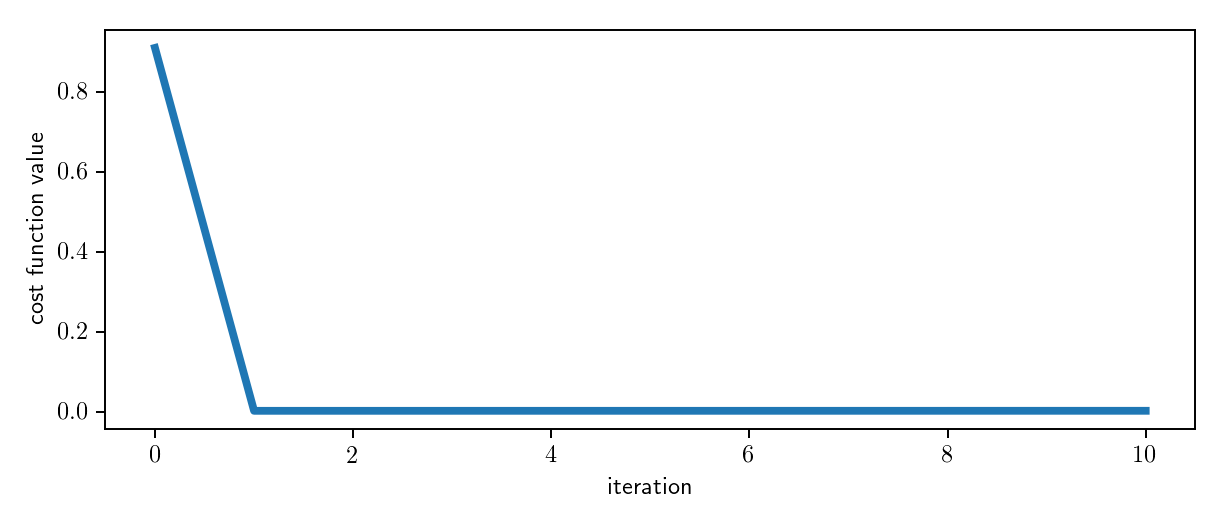

In [29]:
# load in dataset to perform PCA on
X_original = np.loadtxt(datapath + '3d_span_data.csv',delimiter=',')

# mean-center the data
X = center(X_original)

# compute the two-dimensional PCA transformation of dataset
K = 2
C = np.random.randn(3,K)
pcs,W,cost_history = block_coord_PCA(X,C,max_its = 10,lam = 10**(-5))

# plot cost function history
plotter = unsuplib.plot_utilities.Visualizer()
plotter.plot_cost_history(cost_history)

Of course we are able to recover the same subspace as we saw there, but with a non-orthonormal basis (and somewhat random basis).  The effect of this non-orthonormal basis can be most clearly seen in the right panel where the projected data - in the space of the located spanning vectors - is not as evenly distributed as when we used the orthonormal PCA solution.  

<IPython.core.display.Javascript object>


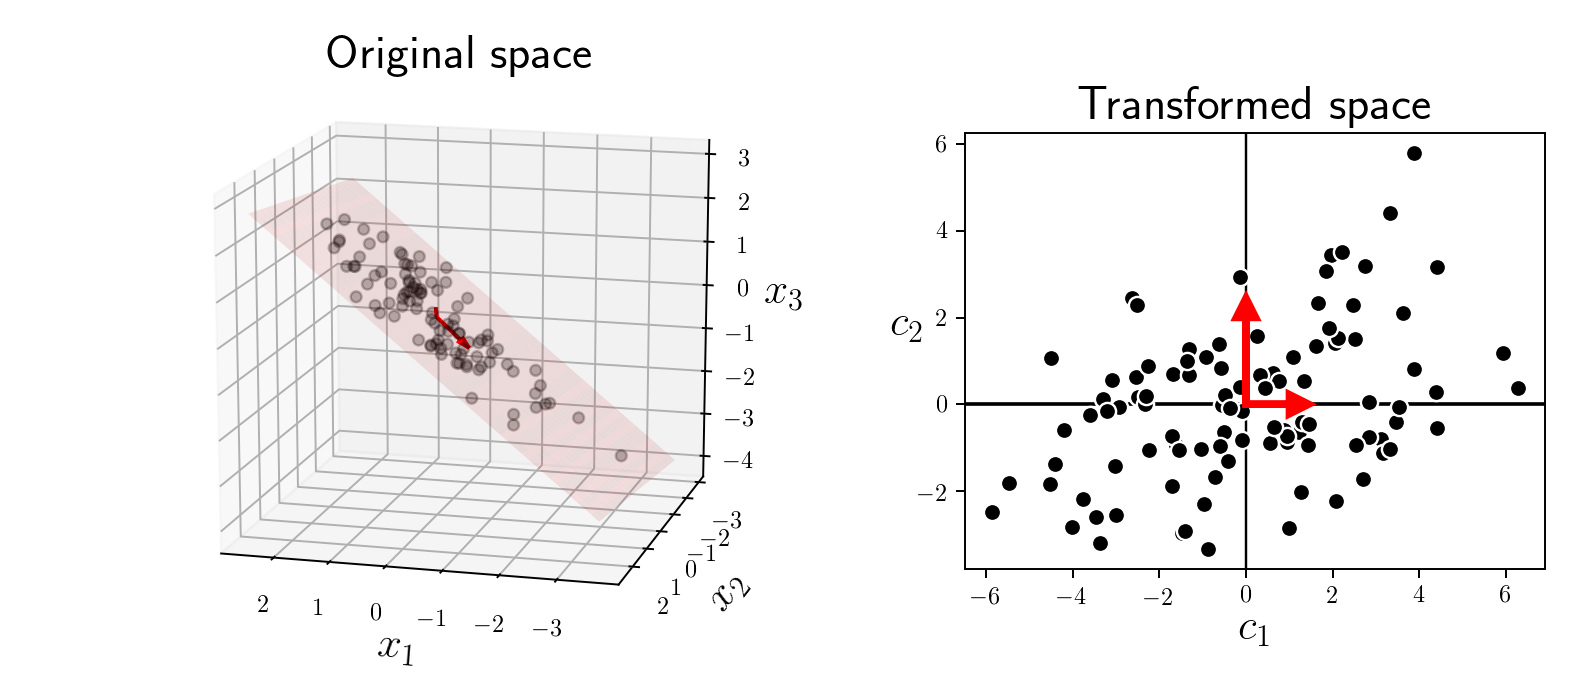

In [30]:
# produce visuals
init = [15,105]
unsuplib.PCA_demos.project_data_from_3d_to_2d(X,W,pcs,init)